## This is a notebook to test the continuation method using the Random Walk formulation

Two ideas: 
- Include a parameter (alpha) that multiplies with the drift coefficient:
- Include a parameter (alpha) that multiplies with the bdry condition: Flow Past Disk, Cavity Flow
  + This may be equivalent to doing a time dependent problem

Train first for alpha = 0 and then ramp up slowly to alpha = 1

In [1]:
import torch
import math
import numpy as np
import time
### Use cuda
dev = torch.device("cuda:0" if torch.cuda.is_available else "cpu")


In [2]:
### Solver Parameters

############## Walker and Boundary Parameters ############

# Time step
dt = 1e-4

# exit tolerance
tol = 1e-6

# Number of walkers
num_walkers = 2**12
num_ghost = 256
num_batch = 2**12

# Update walkers
# Options: 
#    move -- moves walkers to one of their new locations
#    remake -- remake walkers at each training step
#    fixed -- keeps walkers fixed
update_walkers = 'move'
update_walkers_every = 1

# Number of boundary points 
num_bdry = 2**12
num_batch_bdry = 2**12

############## Training Parameters #######################

# Training epochs
num_epoch = 1000
update_print_every = 500

# Trials for Continuation Method
num_trial = 1

# Neural Network Architecture
nn_depth = 60
nn_width = 4

# Weighting of losses
lambda_bell = 1e-2/dt # 1e-2/dt
lambda_bdry = 1e2

# Learning rate
learning_rate = 1e-2
adam_beta = (0.9,0.999)
weight_decay = 0



In [3]:
### Flow Past Disk parameters

#global L_height, v0

############## Save model and/or Load model ##############

savemodel = 'flowpastdisk_test'
loadmodel = ''

# Physical Dimension
x_dim = 2
output_dim = 2

# Steady   or Unsteady
# Elliptic or Parabolic
is_unsteady = False
input_dim = x_dim + is_unsteady

L_height = 0.5
v0 = 5.0

# Diffusion coefficient
mu = 1.0

def bdry_con(X):
    u = torch.zeros( (X.size(0), output_dim), device=X.device)
    return u

def inlet_con(X):
    u = torch.zeros_like(X, device=X.device)
    
    u[:,0] = v0*(L_height - X[:,1])*(L_height + X[:,1])/(L_height**2)

    return u


boundingbox = [ [0, 5*L_height], [-L_height,L_height] ]

bdry1 = {   'type':'disk',
            'centre': [L_height,0],
            'radius': L_height/3,
            'endpoints': [],
            'boundary_condition':bdry_con }

wall_left = {'type':'line',
             'point': [0, -L_height],
             'normal': [1,0],
             'endpoints': [ [0, -L_height], [0, L_height] ],
             'boundary_condition': inlet_con }

wall_top = { 'type':'line',
             'point': [0, L_height],
             'normal':  [0,-1],
             'endpoints': [ [0, L_height], [5*L_height, L_height] ],
             'boundary_condition': bdry_con }

wall_bot = {'type':'line',
             'point': [0,-L_height],
             'normal': [0, 1],
             'endpoints': [ [0, -L_height], [5*L_height, -L_height] ],
             'boundary_condition': bdry_con }

wall_right = {'type':'line',
             'point': [5*L_height, -L_height],
             'normal': [-1,0],
             'endpoints': [ [5*L_height, -L_height], [5*L_height, L_height] ],
             'boundary_condition': inlet_con }

list_of_dirichlet_boundaries = [bdry1, wall_left, wall_top, wall_bot, wall_right]
list_of_periodic_boundaries =[]

In [4]:
### Domain
class Domain:
    ### This class defines the domain using the parameters provided
    ### It sets up the boundingbox and each boundary

    def __init__(self, is_unsteady, boundingbox, 
                list_of_dirichlet_boundaries,
                list_of_periodic_boundaries=False):
        
        self.boundingbox = boundingbox
        self.is_unsteady = is_unsteady

        self.num_of_boundaries = len(list_of_dirichlet_boundaries)
        
        # Unpack dirichlet boundary descriptions
        self.boundaries = []
        for specs in list_of_dirichlet_boundaries:
            ### 2D boundaries
            if specs['type'] == 'line':
                self.boundaries.append( bdry_line( point = specs['point'], 
                                                   normal = specs['normal'],
                                                   endpoints = specs['endpoints'],
                                                   boundary_condition = specs['boundary_condition'] ))
            
            if specs['type'] == 'disk':
                self.boundaries.append( bdry_disk( centre = specs['centre'],
                                                   radius = specs['radius'],
                                                   endpoints = specs['endpoints'], 
                                                   boundary_condition = specs['boundary_condition'] ))
            
            if specs['type'] == 'ring':
                self.boundaries.append( bdry_ring( centre = specs['centre'],
                                                   radius = specs['radius'],
                                                   endpoints = specs['endpoints'], 
                                                   boundary_condition = specs['boundary_condition'] ))
            
            ### 3D boundaries - Note: 2D and 3D boundaries not compatible with each other
            if specs['type'] == 'sphere':
                self.boundaries.append( bdry_sphere( centre = specs['centre'], 
                                                     radius = specs['radius'], 
                                                     boundary_condition = specs['boundary_condition']))
            
            if specs['type'] == 'ball':
                self.boundaries.append( bdry_ball( centre = specs['centre'],
                                                   radius = specs['radius'],
                                                   boundary_condition = specs['boundary_condition']))
            
            if specs['type'] == 'cylinder':
                self.boundaries.append( bdry_cylinder( centre = specs['centre'],
                                                       radius = specs['radius'],
                                                       ### TODO axis of rotation
                                                       boundary_condition = specs['boundary_condition'] ))
            
            if specs['type'] == 'plane':
                self.boundaries.append( bdry_plane( point = specs['point'],
                                                    normal = specs['normal'],
                                                    corners = specs['corners'],
                                                    boundary_condition = specs['boundary_condition']))

        # Unpack any periodic boundaries
        self.periodic_boundaries = []
        for specs in list_of_periodic_boundaries:
            self.periodic_boundaries.append( bdry_periodic( variable = specs['variable'],
                                                            base = specs['base'],
                                                            top = specs['top']  ))

### Boundary Classes

# 2D Boundaries
class bdry_disk:
    ### Class structure for a 2D solid disk boundary, the domain being outside the disk
    
    def __init__(self, centre, radius, endpoints, boundary_condition):
        ### Centre and Radius
        self.centre = torch.tensor( centre )
        self.radius = radius

        self.bdry_cond = boundary_condition
        
        ### Convert endpoints to angles
        ###
        ### Use angles to sample along disk
        if len(endpoints) == 0:
            self.angles = [0, 2*math.pi]
        else:
            self.angles = []
            for point in endpoints:
                self.angles.append( np.angle( np.complex( point[0] - self.centre[0], point[1] - self.centre[1] ) ) )
            if self.angles[1] < self.angles[0]:
                self.angles[1] += 2*math.pi
            
            
    def make_bdry_pts(self, num_bdry, boundingbox, is_unsteady, other_bdrys):
        ### Make points along the boundary as well as the interior
        
        #theta = (self.angles[1] - self.angles[0])*torch.rand((2*num_bdry)) + self.angles[0]
        #inside_rad = self.radius*torch.sqrt( torch.rand(num_bdry) )

        theta_r = torch.cartesian_prod( torch.linspace(0, 2*math.pi, 2**6), self.radius*torch.sqrt( torch.linspace(0,1,2**4) ))
        #rad = self.radius*torch.sqrt( torch.linspace(0,1,2**4) )

            #Xbdry1 = torch.stack((self.radius*torch.cos(theta[:num_bdry]) + self.centre[0],
            #                     self.radius*torch.sin(theta[:num_bdry]) + self.centre[1]), dim=1 )

            #Xbdry2 = torch.stack( (inside_rad*torch.cos(theta[num_bdry:]) + self.centre[0],
            #                         inside_rad*torch.sin(theta[num_bdry:]) + self.centre[1]), dim=1  )

        Xbdry = torch.stack( (theta_r[:,1]*torch.cos(theta_r[:,0]) + self.centre[0],
                                  theta_r[:,1]*torch.sin(theta_r[:,0]) + self.centre[1]), dim=1)

        #Xbdry = torch.cat( (Xbdry1, Xbdry2), dim=0)

        #indices = torch.multinomial( torch.arange( 2*num_bdry, dtype=torch.float ), num_bdry)
        #Xbdry = Xbdry[indices,:]


        ### Check if outside other bdrys
        ### and remake bdry points
        outside = torch.zeros(Xbdry.size(0), dtype=torch.bool)

        for bdry in other_bdrys:
            outside += bdry.dist_to_bdry(Xbdry) < 0
        
        if any(outside):
            Xbdry[outside,:] = self.make_bdry_pts(torch.sum(outside), boundingbox, is_unsteady, other_bdrys)

        return Xbdry
            
    def dist_to_bdry(self, X):
        ### Signed distance to boundary
        ### positive = inside domain
        ### negative = outside domain

        distance = ( torch.norm(X[:,:2] - self.centre.to(X.device),dim=1) - self.radius )
        return distance
    
    def plot_bdry(self, num_bdry):
        ### Give uniformly spaced points along the boundary to plot
        theta = torch.linspace(self.angles[0], self.angles[1], num_bdry)
        Xplot = torch.stack((self.radius*torch.cos(theta) + self.centre[0],
                             self.radius*torch.sin(theta) + self.centre[1]),dim=1 )
        
        return Xplot


class bdry_line:
    ### Class structure for a line boundary
    ###       normal vector points inside
    
    def __init__(self, point, normal, endpoints, boundary_condition):
        self.point = torch.tensor(  point )
        self.normal = torch.tensor( normal )
        self.constant = -sum( self.normal*self.point )
        
        self.bdry_cond = boundary_condition
        
        self.endpoints = torch.tensor(endpoints)
        
    def make_bdry_pts(self, num_bdry, boundingbox, is_unsteady, other_bdrys):
           
        #Xbdry = ( self.endpoints[1] - self.endpoints[0] )*torch.rand((num_bdry,1)) + self.endpoints[0]
        Xbdry = ( self.endpoints[1] - self.endpoints[0] )*torch.linspace(0,1, num_bdry)[:,None] + self.endpoints[0]
        ### Check if outside other bdrys
        ### and remake bdry points
        #outside = torch.zeros(Xbdry.size(0), dtype=torch.bool)

        #for bdry in other_bdrys:
        #    outside += bdry.dist_to_bdry(Xbdry) < 0
        
        #if any(outside):
        #    Xbdry[outside,:] = self.make_bdry_pts(torch.sum(outside), boundingbox, is_unsteady, other_bdrys)

        return Xbdry
    
    def dist_to_bdry(self, X):
        ### Signed distance to boundary
        ### positive = inside domain
        ### negative = outside domain
        distance = torch.sum( self.normal.to(X.device)*X[:,:2], dim=1) + self.constant
        
        return distance
    
    def plot_bdry(self, num_bdry):
        Xplot = ( self.endpoints[1] - self.endpoints[0] )*torch.linspace(0, 1, num_bdry)[:,None] + self.endpoints[0]
        
        return Xplot

class Walker_Data(torch.utils.data.Dataset):
    
    def __init__(self, num_walkers, boundingbox, boundaries):
        
        Xold = generate_interior_points(num_walkers, boundingbox, boundaries)
        #region = close_to_region(Xold)
        
        self.location = Xold
        self.num_pts = num_walkers
        #self.region = region
        
    def __len__(self):
        ### How many data points are there?
        return self.num_pts
    
    def __getitem__(self, index):
        ### Gets one sample of data
        ### 
        return self.location[index,:], index
        
class Boundary_Data(torch.utils.data.Dataset):
    
    def __init__(self, num_bdry, boundingbox, boundaries, is_unsteady):
        
        Xbdry, Ubdry = generate_boundary_points(2**10, boundingbox, boundaries, is_unsteady)
        
        self.location = Xbdry
        self.num_pts = Xbdry.size(0)
        self.value = Ubdry
        
    def __len__(self):
        return self.num_pts
    
    def __getitem__(self, index):
        return self.location[index,:], self.value[index,:]    


def generate_interior_points(num_walkers, boundingbox, boundaries):
    ### Generate points inside the domain

    X = torch.empty( (num_walkers, len(boundingbox)) )

    for ii in range(len(boundingbox)):
        X[:,ii] = (boundingbox[ii][1] - boundingbox[ii][0])*torch.rand( (num_walkers) ) + boundingbox[ii][0]

    outside = torch.zeros( X.size(0), dtype=torch.bool)
    for bdry in boundaries:
        outside += bdry.dist_to_bdry(X) < 0
    
    if any(outside):
        X[outside,:] = generate_interior_points(torch.sum(outside), boundingbox, boundaries)
        
    return X

def generate_boundary_points(num_bdry, boundingbox, boundaries, is_unsteady):
    ### Generate points along the boundary
    
    points_per_bdry = []
    utrue_per_bdry = []
    
    # Generate num_bdry points for each boundary
    for ii in range(len(boundaries)):
        bdry = boundaries[ii]
        other_bdrys = boundaries[:ii] + boundaries[ii+1:]

        # Generate boundary points
        X_in_bdry =  bdry.make_bdry_pts(num_bdry, boundingbox, is_unsteady, other_bdrys)
        U_in_bdry = bdry.bdry_cond(X_in_bdry)

        points_per_bdry.append( X_in_bdry )
        utrue_per_bdry.append( U_in_bdry )

    Xbdry = torch.cat( points_per_bdry, dim=0)
    Ubdry_true = torch.cat( utrue_per_bdry, dim=0)

    # Sample from above boundary points
    #indices = torch.multinomial( torch.arange( len(boundaries)*num_bdry, dtype=torch.float ), num_bdry)
    
    #Xbdry = Xbdry[indices,:]
    #Ubdry_true = Ubdry_true[indices,:]
    
    return Xbdry, Ubdry_true


In [5]:
import DRLPDE_nn

there_are_boundaries = bool(list_of_dirichlet_boundaries)

nn_param = {'depth': nn_depth,
            'width': nn_width,
            'x_dim': x_dim,
            'is_unsteady': is_unsteady,
            'output_dim': output_dim
            }
                  
### Organize parameters related to deep learning solver


################ Preparing the model #################

#print("Initializing the model")

### Make boundaries defining the domain
MyDomain = Domain(is_unsteady, boundingbox, 
                  list_of_dirichlet_boundaries,
                  list_of_periodic_boundaries)

### Initialize the Model
MyNeuralNetwork = DRLPDE_nn.IncompressibleNN

model = MyNeuralNetwork(**nn_param).to(dev)

mseloss = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), 
                        lr=learning_rate, 
                        betas=adam_beta, 
                        weight_decay=weight_decay)

### Create Walkers and Boundary points and Organize into DataLoader
RWalkers = Walker_Data(num_walkers, boundingbox, MyDomain.boundaries)
RWalkers_batch = torch.utils.data.DataLoader(RWalkers, batch_size=num_batch, shuffle=True)

if update_walkers == 'move':
    move_RWalkers = torch.zeros_like(RWalkers.location)

if there_are_boundaries:
    BPoints = Boundary_Data(num_bdry, boundingbox, MyDomain.boundaries, is_unsteady)
    BPoints_batch = torch.utils.data.DataLoader(BPoints, batch_size=num_batch_bdry, shuffle=True)



In [6]:
### Functions

def evaluate_NS(X, model, x_dim, boundaries, mu, dt, num_batch, num_ghost, tol, alpha):
    
    ### Evaluate model
    Uold = model(X)

    ### Move walkers
    
    Xnew = X.repeat(num_ghost,1) - dt*Uold.detach().repeat(num_ghost,1) + np.sqrt(2*mu*dt)*torch.randn((num_batch*num_ghost, x_dim), device=X.device, requires_grad=True)

    Unew = model(Xnew)

    ### Calculate exits and re-evaluate points
    Xnew, Unew, outside = exit_condition(X.repeat(num_ghost,1), Xnew, Unew, boundaries, tol, alpha)

    return Xnew, Uold, Unew, outside[:num_batch]

def exit_condition(Xold, Xnew, Unew, boundaries, tol, alpha):
    ### Calculate exit conditions
    outside = torch.zeros( Xnew.size(0), dtype=torch.bool, device=Xnew.device)
    
    for bdry in boundaries:
        outside_bdry = bdry.dist_to_bdry(Xnew) < 0
        if torch.sum(outside_bdry) > 0:
            ### Bisection to get close to exit location
            ### TODO: should we take a point on the boundary (by projecting or something)
            
            Xnew[outside_bdry,:] = find_bdry_exit(Xold[outside_bdry,:], Xnew[outside_bdry,:], bdry, tol)
            Unew[outside_bdry,:] = alpha*bdry.bdry_cond(Xnew[outside_bdry,:])
            
        outside += outside_bdry

    return Xnew, Unew, outside

def find_bdry_exit(Xold, Xnew, bdry, tol):
    ### Bisection algorithm to find the exit between Xnew and Xold up to a tolerance 
    
    Xmid = (Xnew + Xold)/2
    
    dist = bdry.dist_to_bdry(Xmid)
    
    # above tolerance = inside
    # below tolerance = outside
    above_tol = dist > tol
    below_tol = dist < -tol
    
    if torch.sum(above_tol + below_tol) > 0:
        Xnew[below_tol,:] = Xmid[below_tol,:]
        Xold[above_tol,:] = Xmid[above_tol,:]
        
        Xmid[above_tol + below_tol,:] = find_bdry_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], bdry, tol)

    return Xmid



In [7]:
################ Training the model #################

#print("Training has begun")

start_time = time.time()

### Run the training loop

for trial in range(num_trial):
    #alpha = 0.1*(trial+1)
    alpha = 1

    for step in range(num_epoch):

        # Random Walkers - do in batches
        for Xold, index in RWalkers_batch:

            # Send to GPU and set requires grad flag
            Xold = Xold.to(dev).requires_grad_(True)
            # Xold = Xold.requires_grad_(True)
            # Evaluate at old location and Move walkers
            Xnew, Uold, Unew, outside = evaluate_NS(Xold, model, x_dim, MyDomain.boundaries, mu, dt, num_batch, num_ghost, tol, alpha)

            # Calculate loss
            loss = lambda_bell*mseloss(Uold, Unew.reshape(num_ghost, num_batch, output_dim).mean(0).detach())
            loss.backward()

            # No importance sampling. Walkers just move
            # If moving walkers save the first ghost walker
            if update_walkers == 'move':
                if any(outside):
                    Xnew[:num_batch,:][outside,:] = generate_interior_points(torch.sum(outside),boundingbox,MyDomain.boundaries).to(dev)
                move_RWalkers[index,:] = Xnew[:num_batch].detach().cpu()


        # Boundary Points - do in batches
        if there_are_boundaries:
            for Xbdry, Ubtrue in BPoints_batch:
                Xbdry = Xbdry.to(dev).requires_grad_(True)
                #Xbdry = Xbdry.requires_grad_(True)
                Ubtrue = alpha*Ubtrue.to(dev).detach()
                #Ubtrue = alpha*Ubtrue.detach()
                Ubdry = model(Xbdry)
                loss = lambda_bdry*mseloss(Ubdry, Ubtrue)
                loss.backward()


        # Make optimization step
        optimizer.step()
        optimizer.zero_grad()

        # Update walkers

        if (step+1) % update_walkers_every == 0:
            if update_walkers == 'move':
                RWalkers.location = move_RWalkers
                RWalkers_Batch = torch.utils.data.DataLoader(RWalkers, batch_size=num_batch, shuffle=True)

        # Print statements
        if step == 0:
            print('No errors in first epoch')
            current_time = time.time()
            print('Approx time: {:.0f} minutes'.format((current_time - start_time)*num_epoch/60))
        if (step+1) % update_print_every == 0:
            current_time = time.time()
            print('step = {0}/{1}, {2:2.3f} s/step, time-to-go:{3:2.0f} min'.format(
                    step+1, num_epoch, (current_time - start_time) / (step + 1), 
                (current_time - start_time) / (step + 1) * (num_epoch - step - 1)/60))

# Save model as pickle file

torch.save(model.state_dict(), "savedmodels/" + savemodel + ".pt")




No errors in first epoch
Approx time: 25 minutes
step = 500/1000, 0.215 s/step, time-to-go: 2 min
step = 1000/1000, 0.215 s/step, time-to-go: 0 min


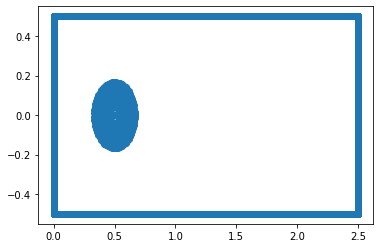

In [8]:
import matplotlib.pyplot as plt

plt.scatter(BPoints.location[:,0].cpu().numpy(),BPoints.location[:,1].cpu().numpy() )